In [ ]:
# Forcing autoreload of modules so restart is not required
%load_ext autoreload
%autoreload 2

import os

os.chdir("../../")


print("Current Working Directory:  ", os.getcwd())

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('./data/processed/NB15/binary_comb/X_train.csv',low_memory=False)
Y_train = pd.read_csv('./data/processed/NB15/binary_comb/Y_train.csv',low_memory=False)


X_test = pd.read_csv('./data/processed/NB15/binary_comb/X_test.csv',low_memory=False)
Y_test = pd.read_csv('./data/processed/NB15/binary_comb/Y_test.csv',low_memory=False)

In [4]:
print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", Y_test.shape)

X_train:  (101010, 195)
Y_train:  (101010, 1)
X_test:  (25928, 195)
y_test:  (25928, 1)


In [ ]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long).squeeze()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long).squeeze()

In [6]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [ ]:
batch_size = 128 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
	def __init__(self, input_dim=195, hidden_dim=64, latent_dim=32):
		super(Autoencoder, self).__init__()
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, latent_dim),
			nn.ReLU()
		)
		self.decoder = nn.Sequential(
			nn.Linear(latent_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, input_dim),
			nn.Sigmoid()  
		)

	def forward(self, x):
		z = self.encoder(x)
		x_recon = self.decoder(z)
		return x_recon

	def extract_features(self, x):
		return self.encoder(x)


In [ ]:
class FFNN(nn.Module):
	def __init__(self, input_dim, hidden_dim=32, num_classes=2):
		super(FFNN, self).__init__()
		self.net = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, num_classes)
		)

	def forward(self, x):
		return self.net(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_autoencoder(model, dataloader, num_epochs=50, lr=1e-3):
	model.to(device)
	optimizer = optim.Adam(model.parameters(), lr=lr)
	criterion = nn.MSELoss()
	loss_history = []

	for epoch in range(num_epochs):
		model.train()
		total_loss = 0
		for x_batch, _ in dataloader:
			x_batch = x_batch.to(device)
			x_recon = model(x_batch)
			loss = criterion(x_recon, x_batch)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			total_loss += loss.item()

		avg_loss = total_loss / len(dataloader)
		loss_history.append(avg_loss)
		print(f"Autoencoder Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

	return loss_history

In [ ]:
def train_ffnn(model, dataloader, num_epochs=50, lr=1e-3):
	model.to(device)
	optimizer = optim.Adam(model.parameters(), lr=lr)
	criterion = nn.CrossEntropyLoss()
	loss_history = []

	for epoch in range(num_epochs):
		model.train()
		total_loss = 0
		for x_batch, y_batch in dataloader:
			x_batch, y_batch = x_batch.to(device), y_batch.to(device).long()
			logits = model(x_batch)
			loss = criterion(logits, y_batch)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			total_loss += loss.item()

		avg_loss = total_loss / len(dataloader)
		loss_history.append(avg_loss)
		print(f"FFNN Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

	return loss_history

In [13]:
autoencoder = Autoencoder(input_dim=195)
autoencoder_loss = train_autoencoder(autoencoder, train_loader)

Autoencoder Epoch [1/50], Loss: 0.1649
Autoencoder Epoch [2/50], Loss: 0.1374
Autoencoder Epoch [3/50], Loss: 0.1351
Autoencoder Epoch [4/50], Loss: 0.1344
Autoencoder Epoch [5/50], Loss: 0.1332
Autoencoder Epoch [6/50], Loss: 0.1329
Autoencoder Epoch [7/50], Loss: 0.1326
Autoencoder Epoch [8/50], Loss: 0.1324
Autoencoder Epoch [9/50], Loss: 0.1323
Autoencoder Epoch [10/50], Loss: 0.1323
Autoencoder Epoch [11/50], Loss: 0.1322
Autoencoder Epoch [12/50], Loss: 0.1322
Autoencoder Epoch [13/50], Loss: 0.1321
Autoencoder Epoch [14/50], Loss: 0.1321
Autoencoder Epoch [15/50], Loss: 0.1321
Autoencoder Epoch [16/50], Loss: 0.1321
Autoencoder Epoch [17/50], Loss: 0.1320
Autoencoder Epoch [18/50], Loss: 0.1320
Autoencoder Epoch [19/50], Loss: 0.1321
Autoencoder Epoch [20/50], Loss: 0.1320
Autoencoder Epoch [21/50], Loss: 0.1319
Autoencoder Epoch [22/50], Loss: 0.1319
Autoencoder Epoch [23/50], Loss: 0.1320
Autoencoder Epoch [24/50], Loss: 0.1319
Autoencoder Epoch [25/50], Loss: 0.1319
Autoencod

In [ ]:
# Extract features
autoencoder.eval()
with torch.no_grad():
	X_train_latent = autoencoder.extract_features(X_train_tensor.to(device)).cpu()
	X_test_latent = autoencoder.extract_features(X_test_tensor.to(device)).cpu()

In [15]:
# Step 3: Train FFNN
ffnn_train_dataset = TensorDataset(X_train_latent, Y_train_tensor)
ffnn_test_dataset = TensorDataset(X_test_latent, Y_test_tensor)

ffnn_train_loader = DataLoader(ffnn_train_dataset, batch_size=128, shuffle=True)
ffnn_test_loader = DataLoader(ffnn_test_dataset, batch_size=128)

ffnn = FFNN(input_dim=X_train_latent.shape[1])
ffnn_loss = train_ffnn(ffnn, ffnn_train_loader)

FFNN Epoch [1/50], Loss: 0.2076
FFNN Epoch [2/50], Loss: 0.1734
FFNN Epoch [3/50], Loss: 0.1550
FFNN Epoch [4/50], Loss: 0.1361
FFNN Epoch [5/50], Loss: 0.1213
FFNN Epoch [6/50], Loss: 0.1104
FFNN Epoch [7/50], Loss: 0.1043
FFNN Epoch [8/50], Loss: 0.1002
FFNN Epoch [9/50], Loss: 0.0973
FFNN Epoch [10/50], Loss: 0.0954
FFNN Epoch [11/50], Loss: 0.0938
FFNN Epoch [12/50], Loss: 0.0929
FFNN Epoch [13/50], Loss: 0.0913
FFNN Epoch [14/50], Loss: 0.0906
FFNN Epoch [15/50], Loss: 0.0904
FFNN Epoch [16/50], Loss: 0.0895
FFNN Epoch [17/50], Loss: 0.0884
FFNN Epoch [18/50], Loss: 0.0880
FFNN Epoch [19/50], Loss: 0.0876
FFNN Epoch [20/50], Loss: 0.0863
FFNN Epoch [21/50], Loss: 0.0857
FFNN Epoch [22/50], Loss: 0.0861
FFNN Epoch [23/50], Loss: 0.0851
FFNN Epoch [24/50], Loss: 0.0846
FFNN Epoch [25/50], Loss: 0.0849
FFNN Epoch [26/50], Loss: 0.0845
FFNN Epoch [27/50], Loss: 0.0840
FFNN Epoch [28/50], Loss: 0.0840
FFNN Epoch [29/50], Loss: 0.0837
FFNN Epoch [30/50], Loss: 0.0833
FFNN Epoch [31/50],

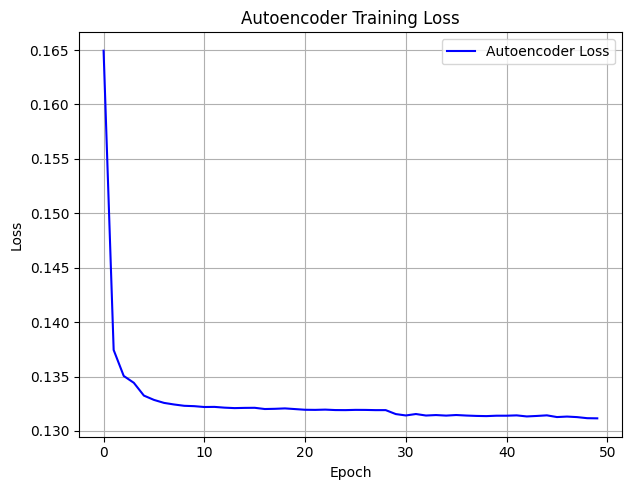

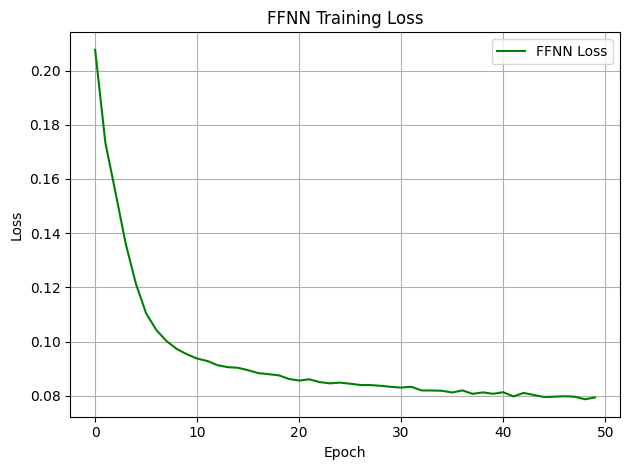

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(autoencoder_loss, label='Autoencoder Loss', color='blue')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


plt.plot(ffnn_loss, label='FFNN Loss', color='green')
plt.title("FFNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from tabulate import tabulate
def evaluate(model, test_loader):
	model.eval()
	all_preds = []
	all_labels = []
	with torch.no_grad():
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device).float(), labels.to(device).squeeze().long()
			outputs = model(inputs)
			_, predicted = torch.max(outputs.data, 1)

			all_preds.extend(predicted.cpu().numpy())
			all_labels.extend(labels.cpu().numpy())
	accuracy = 100 * sum([1 for p, l in zip(all_preds, all_labels) if p == l]) / len(all_labels)
	report = classification_report(all_labels, all_preds, target_names=['0', '1'], output_dict=True)

	headers = ['precision', 'recall', 'f1-score', 'support']
	table_data = []

	for label in ['0', '1']:
		row = [f"{report[label][metric]:.2f}" for metric in headers[:-1]]
		row.append(int(report[label]['support']))
		table_data.append([label] + row)

	table_data.append(['accuracy', '', '', f"{report['accuracy']:.2f}", len(all_labels)])
	table_data.append(['macro avg'] + [f"{report['macro avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['macro avg']['support'])])
	table_data.append(['weighted avg'] + [f"{report['weighted avg'][metric]:.2f}" for metric in headers[:-1]] + [int(report['weighted avg']['support'])])

	print(f"Test Accuracy: {accuracy/100:.4f}")
	print("Classification Report:")
	print(tabulate(table_data, headers=[''] + headers, tablefmt='grid', floatfmt='.2f'))

	report = classification_report(all_labels, all_preds, target_names=['0', '1'], output_dict=True)
	return report

Test Accuracy: 0.8027
Classification Report:
+--------------+-------------+----------+------------+-----------+
|              | precision   | recall   |   f1-score |   support |
+==============+=============+==========+============+===========+
| 0            | 0.81        | 0.98     |       0.89 |     20520 |
+--------------+-------------+----------+------------+-----------+
| 1            | 0.62        | 0.14     |       0.23 |      5408 |
+--------------+-------------+----------+------------+-----------+
| accuracy     |             |          |       0.80 |     25928 |
+--------------+-------------+----------+------------+-----------+
| macro avg    | 0.72        | 0.56     |       0.56 |     25928 |
+--------------+-------------+----------+------------+-----------+
| weighted avg | 0.77        | 0.80     |       0.75 |     25928 |
+--------------+-------------+----------+------------+-----------+


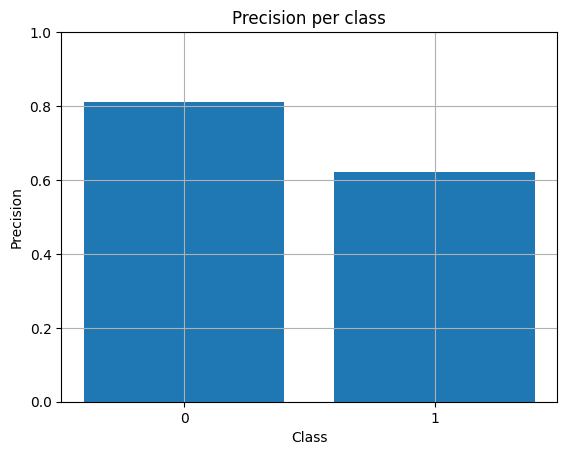

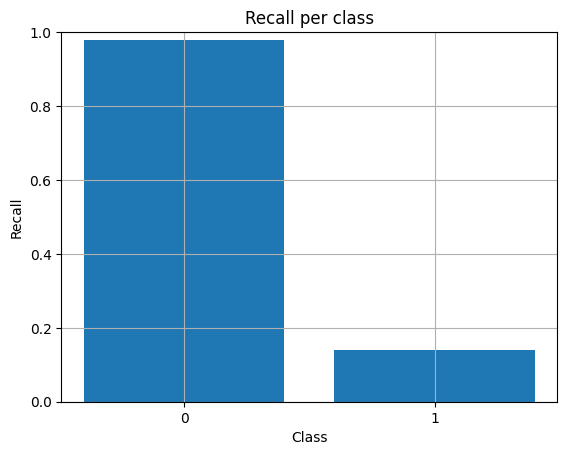

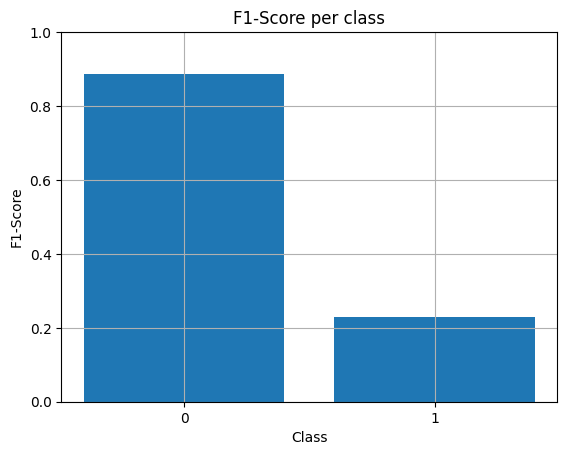

In [ ]:
report = evaluate(ffnn, ffnn_test_loader)

metrics = ['precision', 'recall', 'f1-score']
classes = ['0', '1']

for metric in metrics:
	values = [report[cls][metric] for cls in classes]
	plt.bar(classes, values)
	plt.ylim(0, 1)
	plt.title(f"{metric.title()} per class")
	plt.xlabel("Class")
	plt.ylabel(metric.title())
	plt.grid(True)
	plt.show()
